In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from pathlib import Path
from PIL import Image

# Configure matplotlib for larger displays
plt.rcParams["figure.figsize"] = (12, 6)

In [19]:
def build_features(img_bgr, use_xy=True, xy_scale=0.01):
    """
    Converts image to feature matrix (Lab Color Space).
    Returns: (N_pixels, N_features), (height, width)
    """
    # Convert to Lab (L: Lightness, a: Green-Red, b: Blue-Yellow)
    # L range: 0-255, a/b range: 0-255 (128 is neutral)
    img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB).astype(np.float32)
    h, w = img_lab.shape[:2]
    
    L = img_lab[:,:,0].reshape(-1,1)
    a = img_lab[:,:,1].reshape(-1,1)
    b = img_lab[:,:,2].reshape(-1,1)
    feats = np.concatenate([L, a, b], axis=1)
    
    # We generally disable XY for the "Train Small, Predict Large" workflow
    if use_xy:
        xs, ys = np.meshgrid(np.arange(w), np.arange(h))
        xs = xs.reshape(-1,1).astype(np.float32) * xy_scale
        ys = ys.reshape(-1,1).astype(np.float32) * xy_scale
        feats = np.concatenate([feats, xs, ys], axis=1)
        
    return feats, (h, w)

def predict_in_chunks(model, features, chunk_size=50000):
    """
    Runs GMM prediction in small batches.
    Prevents RAM crashes on large 12MP+ images.
    """
    n_samples = features.shape[0]
    predictions = []
    
    for i in range(0, n_samples, chunk_size):
        chunk = features[i : i + chunk_size]
        pred_chunk = model.predict(chunk)
        predictions.append(pred_chunk)
        
    return np.concatenate(predictions)

def postprocess_mask(mask, min_area=500):
    """
    Cleans noise specks and fills small holes in the object.
    """
    # Close small holes
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Keep only significant blobs
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    out = np.zeros_like(mask)
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_area:
            out[labels==i] = 255
    return out
def gmm_segment_background_target(img_bgr, n_components=3, train_scale=0.05, random_state=42):
    """
    STRATEGY: Target the White Paper (Background), then Invert.
    Best for datasets with consistent backgrounds but variable objects.
    """
    # --- A. TRAIN PHASE (Small Image) ---
    h_full, w_full = img_bgr.shape[:2]
    w_small = max(100, int(w_full * train_scale))
    h_small = max(100, int(h_full * train_scale))
    
    img_small = cv2.resize(img_bgr, (w_small, h_small))
    feats_small, _ = build_features(img_small, use_xy=False)
    
    gm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=random_state)
    gm.fit(feats_small)
    
    # --- B. FIND BACKGROUND (Closest to White) ---
    # In Lab: White = [255, 128, 128]
    cluster_means = gm.means_
    white_ref = np.array([255.0, 128.0, 128.0])
    
    # Calculate distance to white for every cluster
    distances = np.linalg.norm(cluster_means - white_ref, axis=1)
    
    # Pick the cluster with the SMALLEST distance (The Paper)
    bg_cluster = int(np.argmin(distances))
    
    # --- C. PREDICT & INVERT ---
    feats_full, _ = build_features(img_bgr, use_xy=False)
    labels_full = predict_in_chunks(gm, feats_full, chunk_size=50000)
    labels_img = labels_full.reshape(h_full, w_full)
    
    # Create Background Mask (White pixels = 255)
    bg_mask = (labels_img == bg_cluster).astype('uint8') * 255
    
    # INVERT: Banana is everything that is NOT the background
    # (255 - 255 = 0, 255 - 0 = 255)
    fg_mask = cv2.bitwise_not(bg_mask)
    
    return fg_mask, labels_img

def gmm_segment_universal(img_bgr, n_components=3, train_scale=0.05, random_state=42):
    """
    Robust pipeline for Yellow AND Black/Rotten bananas.
    1. Trains on small resize (fast).
    2. Identifies Banana by finding the cluster FURTHEST from White Paper.
    3. Predicts full resolution in memory-safe chunks.
    """
    # --- A. TRAIN PHASE (Small Image) ---
    h_full, w_full = img_bgr.shape[:2]
    # Ensure resize isn't too tiny (keep at least 100px)
    w_small = max(100, int(w_full * train_scale))
    h_small = max(100, int(h_full * train_scale))
    
    img_small = cv2.resize(img_bgr, (w_small, h_small))
    
    # Disable XY so model learns pure color distribution
    feats_small, _ = build_features(img_small, use_xy=False)
    
    gm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=random_state)
    gm.fit(feats_small)
    
    # --- B. ROBUST HEURISTIC (Distance from White) ---
    # In OpenCV Lab: White is approx [255, 128, 128]
    # Yellow Banana: High distance (due to color)
    # Black Banana: High distance (due to low lightness)
    # Background: Low distance (it IS white)
    
    cluster_means = gm.means_ # Shape: (n_components, 3) [L, a, b]
    white_ref = np.array([255.0, 128.0, 128.0])
    
    # Calculate Euclidean distance of each cluster center from Pure White
    distances = np.linalg.norm(cluster_means - white_ref, axis=1)
    
    # The cluster furthest from white is our object
    chosen_cluster = int(np.argmax(distances))
    
    # --- C. PREDICT PHASE (Full Image) ---
    feats_full, _ = build_features(img_bgr, use_xy=False)
    
    # Predict in chunks to save memory
    labels_full = predict_in_chunks(gm, feats_full, chunk_size=50000)
    labels_img = labels_full.reshape(h_full, w_full)
    
    # Create Binary Mask
    mask = (labels_img == chosen_cluster).astype('uint8') * 255
    
    return mask, labels_img

def gmm_segment_aggressive_white(img_bgr, n_components=4, train_scale=0.05, random_state=42, white_threshold=80):
    """
    AGGRESSIVE WHITE TARGETING.
    1. Splits image into more components (default 4) to isolate shadows.
    2. Treats ANY cluster close to White (within white_threshold) as background.
    3. Captures grays/shadows better than the single-cluster approach.
    """
    # --- A. TRAIN PHASE ---
    h_full, w_full = img_bgr.shape[:2]
    w_small = max(100, int(w_full * train_scale))
    h_small = max(100, int(h_full * train_scale))
    
    img_small = cv2.resize(img_bgr, (w_small, h_small))
    feats_small, _ = build_features(img_small, use_xy=False)
    
    # Increase components to separate "Paper" from "Shadows" from "Banana"
    gm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=random_state)
    gm.fit(feats_small)
    
    # --- B. IDENTIFY ALL BACKGROUND CLUSTERS ---
    # In Lab: Pure White = [255, 128, 128] (High Lightness, Neutral Color)
    cluster_means = gm.means_
    white_ref = np.array([255.0, 128.0, 128.0])
    
    # Calculate Euclidean distance from Pure White for EVERY cluster
    distances = np.linalg.norm(cluster_means - white_ref, axis=1)
    
    # AGGRESSIVE LOGIC:
    # Instead of just taking the min(), we take ANY cluster closer than 'white_threshold'.
    # A threshold of ~80-90 usually catches Grey Shadows (L~170) but excludes Yellow (due to 'b' channel).
    bg_cluster_indices = np.where(distances < white_threshold)[0]
    
    # Fallback: If threshold is too strict and finds nothing, just take the closest one.
    if len(bg_cluster_indices) == 0:
        bg_cluster_indices = [np.argmin(distances)]
        
    # --- C. PREDICT & MASK ---
    feats_full, _ = build_features(img_bgr, use_xy=False)
    labels_full = predict_in_chunks(gm, feats_full, chunk_size=50000)
    labels_img = labels_full.reshape(h_full, w_full)
    
    # Create a Combined Background Mask
    # We start with all zeros, then set pixels to 255 if they belong to ANY background cluster
    bg_mask = np.zeros(labels_img.shape, dtype='uint8')
    for idx in bg_cluster_indices:
        bg_mask[labels_img == idx] = 255
    
    # INVERT to get Foreground
    fg_mask = cv2.bitwise_not(bg_mask)
    
    return fg_mask, labels_img

Testing on dataset/H1/Vivo_27_H1f1_Kanan.jpg...


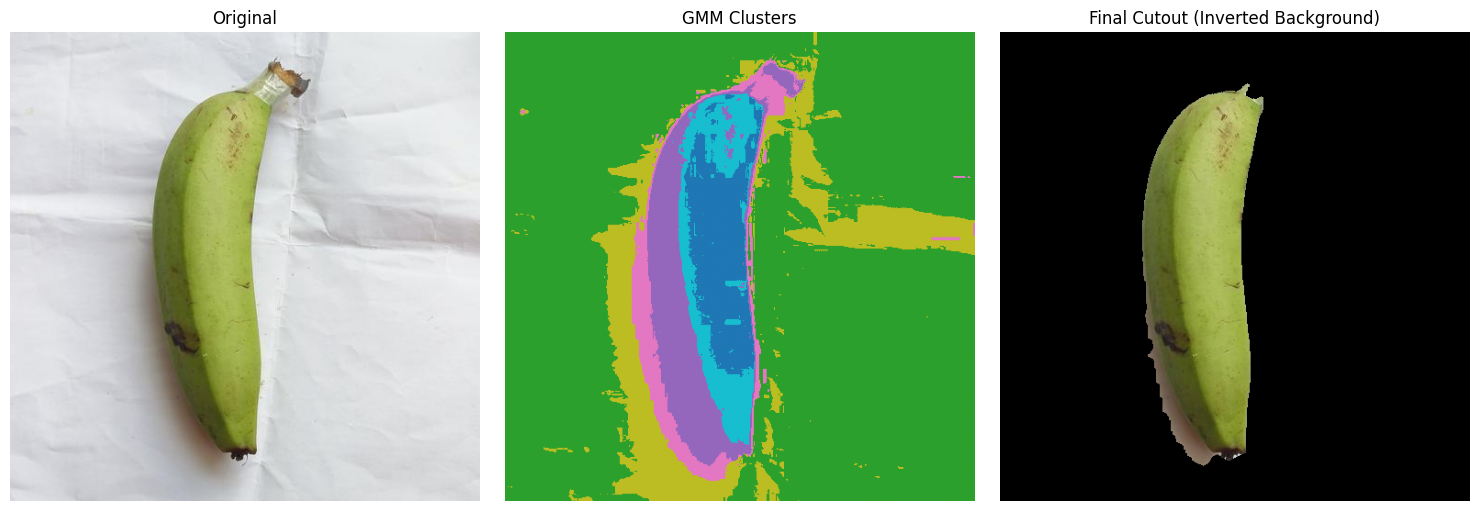

In [27]:
# Test on one image
test_path = 'dataset/H1/Vivo_27_H1f1_Kanan.jpg' # Replace with valid path for testing
img_test = cv2.imread(test_path)

if img_test is not None:
    print(f"Testing on {test_path}...")

    # UPDATE: Use the new Background-Targeting function
    mask, labels = gmm_segment_aggressive_white(img_test, n_components=6, white_threshold=90)
    
    # Clean up small holes/noise
    mask_clean = postprocess_mask(mask, min_area=1000)
    
    # Create cutout visualization
    img_rgb = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
    cutout = img_rgb.copy()
    cutout[mask_clean == 0] = 0 # Set background to black

    # Display
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1. Original
    ax[0].imshow(img_rgb)
    ax[0].set_title("Original")
    
    # 2. Raw Clusters (Visual check for "Leaking")
    ax[1].imshow(labels, cmap='tab10') # Changed to tab10 for distinct colors
    ax[1].set_title("GMM Clusters")
    
    # 3. Final Result (Background removed)
    ax[2].imshow(cutout)
    ax[2].set_title("Final Cutout (Inverted Background)")
    
    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Test image not found. Skipping visualization.")

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from pathlib import Path
from PIL import Image

# ==========================================
# 1. SEGMENTATION LOGIC
# ==========================================

def build_features(img_bgr, use_xy=True, xy_scale=0.01):
    img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB).astype(np.float32)
    h, w = img_lab.shape[:2]
    L = img_lab[:,:,0].reshape(-1,1)
    a = img_lab[:,:,1].reshape(-1,1)
    b = img_lab[:,:,2].reshape(-1,1)
    feats = np.concatenate([L, a, b], axis=1)
    
    if use_xy:
        xs, ys = np.meshgrid(np.arange(w), np.arange(h))
        xs = xs.reshape(-1,1).astype(np.float32) * xy_scale
        ys = ys.reshape(-1,1).astype(np.float32) * xy_scale
        feats = np.concatenate([feats, xs, ys], axis=1)
        
    return feats, (h, w)

def predict_in_chunks(model, features, chunk_size=50000):
    predictions = []
    for i in range(0, features.shape[0], chunk_size):
        chunk = features[i : i + chunk_size]
        predictions.append(model.predict(chunk))
    return np.concatenate(predictions)

def postprocess_mask(mask, min_area=500):
    """
    Refined Post-processing:
    1. Smooths edges.
    2. FILLS HOLES inside the object using Contour Filling.
    """
    # 1. Morphological Closing (Connects small gaps in the edge)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # 2. FILL HOLES STRATEGY:
    # Find contours using RETR_EXTERNAL (this ignores internal hole contours)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a fresh black mask
    out = np.zeros_like(mask)
    
    for c in contours:
        if cv2.contourArea(c) >= min_area:
            # Draw the contour FILLED (thickness=-1)
            # This paints the entire interior white, effectively patching any holes
            cv2.drawContours(out, [c], -1, 255, thickness=cv2.FILLED)
            
    return out

def gmm_segment_aggressive_white(img_bgr, n_components=4, train_scale=0.05, random_state=42, white_threshold=90):
    # 1. Train on Small
    h_full, w_full = img_bgr.shape[:2]
    w_small = max(100, int(w_full * train_scale))
    h_small = max(100, int(h_full * train_scale))
    img_small = cv2.resize(img_bgr, (w_small, h_small))
    feats_small, _ = build_features(img_small, use_xy=False)
    
    gm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=random_state)
    gm.fit(feats_small)
    
    # 2. Identify Background Clusters (Aggressive)
    white_ref = np.array([255.0, 128.0, 128.0])
    distances = np.linalg.norm(gm.means_ - white_ref, axis=1)
    
    # Select ANY cluster closer than 'white_threshold'
    bg_cluster_indices = np.where(distances < white_threshold)[0]
    if len(bg_cluster_indices) == 0:
        bg_cluster_indices = [np.argmin(distances)] # Fallback

    # 3. Predict Full & Mask
    feats_full, _ = build_features(img_bgr, use_xy=False)
    labels_full = predict_in_chunks(gm, feats_full)
    labels_img = labels_full.reshape(h_full, w_full)
    
    bg_mask = np.zeros(labels_img.shape, dtype='uint8')
    for idx in bg_cluster_indices:
        bg_mask[labels_img == idx] = 255
        
    return cv2.bitwise_not(bg_mask), labels_img

# ==========================================
# 2. BATCH PROCESSING LOOP
# ==========================================

root = Path('/mnt/libraries/pola/dataset/') 
out_dir = Path('segmented_masks_gmm')

if root.exists():
    files = sorted(list(root.rglob('*.jpg')))
    print(f"Found {len(files)} images. Processing...")

    for i, p in enumerate(files):
        rel_path = p.relative_to(root)
        dest_folder = out_dir / rel_path.parent
        dest_folder.mkdir(parents=True, exist_ok=True)
        
        # Define paths for BOTH outputs
        mask_path = dest_folder / (p.stem + '_mask.png')
        cutout_path = dest_folder / (p.stem + '_cutout.png')

        if mask_path.exists() and cutout_path.exists():
            continue

        print(f"[{i+1}/{len(files)}] Processing {rel_path}...")
        
        img = cv2.imread(str(p))
        if img is None: continue

        try:
            # A. SEGMENT
            mask, _ = gmm_segment_aggressive_white(img, n_components=7, white_threshold=90)
            
            # B. POST-PROCESS (Now patches holes!)
            mask_clean = postprocess_mask(mask, min_area=500)
            
            # C. SAVE MASK
            Image.fromarray(mask_clean).save(mask_path)
            
            # D. SAVE CUTOUT
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            b, g, r = cv2.split(img)
            rgba = cv2.merge([r, g, b, mask_clean]) 
            Image.fromarray(rgba).save(cutout_path)
            
        except Exception as e:
            print(f"  Failed on {p.name}: {e}")

    print(f"\nBatch complete. Outputs saved to: {out_dir}")
else:
    print(f"Root path {root} not found.")

/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3103/3280] Processing H9/Realme_24_H9F1_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3104/3280] Processing H9/Realme_24_H9F1_Kiri.jpg...
[3105/3280] Processing H9/Realme_24_H9F2_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3106/3280] Processing H9/Realme_24_H9F2_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3107/3280] Processing H9/Realme_25_H9F1_Kanan.jpg...
[3108/3280] Processing H9/Realme_25_H9F1_Kiri.jpg...
[3109/3280] Processing H9/Realme_25_H9F2_Kanan.jpg...
[3110/3280] Processing H9/Realme_25_H9F2_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3111/3280] Processing H9/Realme_26_H9F1_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3112/3280] Processing H9/Realme_26_H9F1_Kiri.jpg...
[3113/3280] Processing H9/Realme_26_H9F2_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3114/3280] Processing H9/Realme_26_H9F2_Kiri.jpg...
[3115/3280] Processing H9/Realme_27_H9F1_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3116/3280] Processing H9/Realme_27_H9F1_Kiri.jpg...
[3117/3280] Processing H9/Realme_27_H9F2_Kanan.jpg...
[3118/3280] Processing H9/Realme_27_H9F2_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3119/3280] Processing H9/Realme_28_H9F1_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3120/3280] Processing H9/Realme_28_H9F1_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3121/3280] Processing H9/Realme_28_H9F2_Kanan.jpg...
[3122/3280] Processing H9/Realme_28_H9F2_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3123/3280] Processing H9/Realme_29_H9F1_Kanan.jpg...
[3124/3280] Processing H9/Realme_29_H9F1_Kiri.jpg...
[3125/3280] Processing H9/Realme_29_H9F2_Kanan.jpg...
[3126/3280] Processing H9/Realme_29_H9F2_Kiri.jpg...
[3127/3280] Processing H9/Realme_2_H9F1_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3128/3280] Processing H9/Realme_2_H9F1_Kiri.jpg...
[3129/3280] Processing H9/Realme_30_H9F1_Kanan.jpg...
[3130/3280] Processing H9/Realme_30_H9F1_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3131/3280] Processing H9/Realme_30_H9F2_Kanan.jpg...
[3132/3280] Processing H9/Realme_30_H9F2_Kiri.jpg...
[3133/3280] Processing H9/Realme_3_H9F1_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3134/3280] Processing H9/Realme_3_H9F1_Kiri.jpg...
[3135/3280] Processing H9/Realme_3_H9F2_Kanan.jpg...
[3136/3280] Processing H9/Realme_3_H9F2_Kiri.jpg...
[3137/3280] Processing H9/Realme_4_H9F1_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3138/3280] Processing H9/Realme_4_H9F1_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3139/3280] Processing H9/Realme_4_H9F2_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3140/3280] Processing H9/Realme_4_H9F2_Kiri.jpg...
[3141/3280] Processing H9/Realme_5_H9F1_Kanan.jpg...
[3142/3280] Processing H9/Realme_5_H9F1_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3143/3280] Processing H9/Realme_5_H9F2_Kanan.jpg...
[3144/3280] Processing H9/Realme_5_H9F2_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3145/3280] Processing H9/Realme_6_H9F1_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3146/3280] Processing H9/Realme_6_H9F1_Kiri.jpg...
[3147/3280] Processing H9/Realme_6_H9F2_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3148/3280] Processing H9/Realme_6_H9F2_Kiri.jpg...
[3149/3280] Processing H9/Realme_7_H9F1_Kanan.jpg...
[3150/3280] Processing H9/Realme_7_H9F1_Kiri.jpg...
[3151/3280] Processing H9/Realme_7_H9F2_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3152/3280] Processing H9/Realme_7_H9F2_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3153/3280] Processing H9/Realme_8_H9F1_Kanan.jpg...
[3154/3280] Processing H9/Realme_8_H9F1_Kiri.jpg...
[3155/3280] Processing H9/Realme_8_H9F2_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3156/3280] Processing H9/Realme_8_H9F2_Kiri.jpg...
[3157/3280] Processing H9/Realme_9_H9F1_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3158/3280] Processing H9/Realme_9_H9F1_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3159/3280] Processing H9/Realme_9_H9F2_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3160/3280] Processing H9/Realme_9_H9F2_Kiri.jpg...
[3161/3280] Processing H9/Vivo_10_H9f1_Kanan.jpg...
[3162/3280] Processing H9/Vivo_10_H9f1_Kiri.jpg...
[3163/3280] Processing H9/Vivo_10_H9f2_Kanan.jpg...
[3164/3280] Processing H9/Vivo_10_H9f2_Kiri.jpg...
[3165/3280] Processing H9/Vivo_11_H9f1_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3166/3280] Processing H9/Vivo_11_H9f1_Kiri.jpg...
[3167/3280] Processing H9/Vivo_11_H9f2_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3168/3280] Processing H9/Vivo_11_H9f2_Kiri.jpg...
[3169/3280] Processing H9/Vivo_12_H9f1_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3170/3280] Processing H9/Vivo_12_H9f1_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3171/3280] Processing H9/Vivo_12_H9f2_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3172/3280] Processing H9/Vivo_12_H9f2_Kiri.jpg...
[3173/3280] Processing H9/Vivo_13_H9f1_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3174/3280] Processing H9/Vivo_13_H9f1_Kiri.jpg...
[3175/3280] Processing H9/Vivo_13_H9f2_Kanan.jpg...
[3176/3280] Processing H9/Vivo_13_H9f2_Kiri.jpg...
[3177/3280] Processing H9/Vivo_14_H9f1_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3178/3280] Processing H9/Vivo_14_H9f1_Kiri.jpg...
[3179/3280] Processing H9/Vivo_14_H9f2_Kanan.jpg...
[3180/3280] Processing H9/Vivo_14_H9f2_Kiri.jpg...
[3181/3280] Processing H9/Vivo_15_H9f1_Kanan.jpg...
[3182/3280] Processing H9/Vivo_15_H9f1_Kiri.jpg...
[3183/3280] Processing H9/Vivo_15_H9f2_Kanan.jpg...
[3184/3280] Processing H9/Vivo_15_H9f2_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3185/3280] Processing H9/Vivo_16_H9f1_Kanan.jpg...
[3186/3280] Processing H9/Vivo_16_H9f1_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3187/3280] Processing H9/Vivo_16_H9f2_Kanan.jpg...
[3188/3280] Processing H9/Vivo_16_H9f2_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3189/3280] Processing H9/Vivo_17_H9f1_Kanan.jpg...
[3190/3280] Processing H9/Vivo_17_H9f1_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3191/3280] Processing H9/Vivo_17_H9f2_Kanan.jpg...
[3192/3280] Processing H9/Vivo_17_H9f2_Kiri.jpg...
[3193/3280] Processing H9/Vivo_18_H9f1_Kanan.jpg...
[3194/3280] Processing H9/Vivo_18_H9f1_Kiri.jpg...
[3195/3280] Processing H9/Vivo_18_H9f2_Kanan.jpg...
[3196/3280] Processing H9/Vivo_18_H9f2_Kiri.jpg...
[3197/3280] Processing H9/Vivo_19_H9f1_Kanan.jpg...
[3198/3280] Processing H9/Vivo_19_H9f1_Kiri.jpg...
[3199/3280] Processing H9/Vivo_19_H9f2_Kanan.jpg...
[3200/3280] Processing H9/Vivo_19_H9f2_Kiri.jpg...
[3201/3280] Processing H9/Vivo_1_H9f1_Kanan.jpg...
[3202/3280] Processing H9/Vivo_1_H9f1_Kiri.jpg...
[3203/3280] Processing H9/Vivo_1_H9f2_Kanan.jpg...
[3204/3280] Processing H9/Vivo_1_H9f2_Kiri.jpg...
[3205/3280] Processing H9/Vivo_20_H9f1_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3206/3280] Processing H9/Vivo_20_H9f1_Kiri.jpg...
[3207/3280] Processing H9/Vivo_20_H9f2_Kanan.jpg...
[3208/3280] Processing H9/Vivo_20_H9f2_Kiri.jpg...
[3209/3280] Processing H9/Vivo_21_H9f1_Kanan.jpg...
[3210/3280] Processing H9/Vivo_21_H9f1_Kiri.jpg...
[3211/3280] Processing H9/Vivo_21_H9f2_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3212/3280] Processing H9/Vivo_21_H9f2_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3213/3280] Processing H9/Vivo_22_H9f1_Kanan.jpg...
[3214/3280] Processing H9/Vivo_22_H9f1_Kiri.jpg...
[3215/3280] Processing H9/Vivo_22_H9f2_Kanan.jpg...
[3216/3280] Processing H9/Vivo_22_H9f2_Kiri.jpg...
[3217/3280] Processing H9/Vivo_23_H9f1_Kanan.jpg...
[3218/3280] Processing H9/Vivo_23_H9f1_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3219/3280] Processing H9/Vivo_23_H9f2_Kanan.jpg...
[3220/3280] Processing H9/Vivo_23_H9f2_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3221/3280] Processing H9/Vivo_24_H9f1_Kanan.jpg...
[3222/3280] Processing H9/Vivo_24_H9f1_Kiri.jpg...
[3223/3280] Processing H9/Vivo_24_H9f2_Kanan.jpg...
[3224/3280] Processing H9/Vivo_24_H9f2_Kiri.jpg...
[3225/3280] Processing H9/Vivo_25_H9f1_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3226/3280] Processing H9/Vivo_25_H9f1_Kiri.jpg...
[3227/3280] Processing H9/Vivo_25_H9f2_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3228/3280] Processing H9/Vivo_25_H9f2_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3229/3280] Processing H9/Vivo_26_H9f1_Kanan.jpg...
[3230/3280] Processing H9/Vivo_26_H9f1_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3231/3280] Processing H9/Vivo_26_H9f2_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3232/3280] Processing H9/Vivo_26_H9f2_Kiri.jpg...
[3233/3280] Processing H9/Vivo_27_H9f1_Kanan.jpg...
[3234/3280] Processing H9/Vivo_27_H9f1_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3235/3280] Processing H9/Vivo_27_H9f2_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3236/3280] Processing H9/Vivo_27_H9f2_Kiri.jpg...
[3237/3280] Processing H9/Vivo_28_H9f1_Kanan.jpg...
[3238/3280] Processing H9/Vivo_28_H9f1_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3239/3280] Processing H9/Vivo_28_H9f2_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3240/3280] Processing H9/Vivo_28_H9f2_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3241/3280] Processing H9/Vivo_29_H9f1_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3242/3280] Processing H9/Vivo_29_H9f1_Kiri.jpg...
[3243/3280] Processing H9/Vivo_29_H9f2_Kanan.jpg...
[3244/3280] Processing H9/Vivo_29_H9f2_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3245/3280] Processing H9/Vivo_2_H9f1_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3246/3280] Processing H9/Vivo_2_H9f1_Kiri.jpg...
[3247/3280] Processing H9/Vivo_2_H9f2_Kanan.jpg...
[3248/3280] Processing H9/Vivo_2_H9f2_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3249/3280] Processing H9/Vivo_30_H9f1_Kanan.jpg...
[3250/3280] Processing H9/Vivo_30_H9f1_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3251/3280] Processing H9/Vivo_30_H9f2_Kanan.jpg...
[3252/3280] Processing H9/Vivo_30_H9f2_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3253/3280] Processing H9/Vivo_3_H9f1_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3254/3280] Processing H9/Vivo_3_H9f1_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3255/3280] Processing H9/Vivo_3_H9f2_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3256/3280] Processing H9/Vivo_3_H9f2_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3257/3280] Processing H9/Vivo_4_H9f1_Kanan.jpg...
[3258/3280] Processing H9/Vivo_4_H9f1_Kiri.jpg...
[3259/3280] Processing H9/Vivo_4_H9f2_Kanan.jpg...
[3260/3280] Processing H9/Vivo_4_H9f2_Kiri.jpg...
[3261/3280] Processing H9/Vivo_5_H9f1_Kanan.jpg...
[3262/3280] Processing H9/Vivo_5_H9f1_Kiri.jpg...
[3263/3280] Processing H9/Vivo_5_H9f2_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3264/3280] Processing H9/Vivo_5_H9f2_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3265/3280] Processing H9/Vivo_6_H9f1_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3266/3280] Processing H9/Vivo_6_H9f1_Kiri.jpg...
[3267/3280] Processing H9/Vivo_6_H9f2_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3268/3280] Processing H9/Vivo_6_H9f2_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3269/3280] Processing H9/Vivo_7_H9f1_Kanan.jpg...
[3270/3280] Processing H9/Vivo_7_H9f1_Kiri.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3271/3280] Processing H9/Vivo_7_H9f2_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3272/3280] Processing H9/Vivo_7_H9f2_Kiri.jpg...
[3273/3280] Processing H9/Vivo_8_H9f1_Kanan.jpg...


/mnt/libraries/pola/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[3274/3280] Processing H9/Vivo_8_H9f1_Kiri.jpg...
[3275/3280] Processing H9/Vivo_8_H9f2_Kanan.jpg...
[3276/3280] Processing H9/Vivo_8_H9f2_Kiri.jpg...
[3277/3280] Processing H9/Vivo_9_H9f1_Kanan.jpg...
[3278/3280] Processing H9/Vivo_9_H9f1_Kiri.jpg...
[3279/3280] Processing H9/Vivo_9_H9f2_Kanan.jpg...
[3280/3280] Processing H9/Vivo_9_H9f2_Kiri.jpg...

Batch complete. Outputs saved to: segmented_masks_gmm
